In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM


#Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','class','difficulty_level']

In [ ]:
train_set= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain+.txt", names = features)
test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest+.txt", names = features)

In [ ]:
#Training splits
train_set, val_set = train_test_split(train_set, test_size = 0.3, random_state = 42)

In [ ]:
train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [ ]:
"""combined_data = pd.concat([train_set, val_set, test_set])
#deleting duplicated instances
repetitive_instances = combined_data.duplicated().sum()
print("Number of repetitive instances:", repetitive_instances)
combined_data.drop_duplicates(inplace=True)
combined_data.shape #2520798,79
#duplicated instances that have same columns except for the label
duplicate_instances = combined_data.duplicated(subset=combined_data.columns[:-1], keep=False)
duplicated_rows = combined_data[duplicate_instances]
print("duplicates where all columns except for the label are the same :",duplicated_rows.shape[0])
combined_data.drop_duplicates(subset=combined_data.columns[:-1], keep=False, inplace=True)
print("after deleting them we get : ", combined_data.shape[0])
#train_set, val_set = train_test_split(combined_data, test_size = 0.4, random_state = 42)
#val_set, test_set = train_test_split(val_set, test_size = 0.5, random_state = 42)"""

'combined_data = pd.concat([train_set, val_set, test_set])\n#deleting duplicated instances\nrepetitive_instances = combined_data.duplicated().sum()\nprint("Number of repetitive instances:", repetitive_instances)\ncombined_data.drop_duplicates(inplace=True)\ncombined_data.shape #2520798,79\n#duplicated instances that have same columns except for the label\nduplicate_instances = combined_data.duplicated(subset=combined_data.columns[:-1], keep=False)\nduplicated_rows = combined_data[duplicate_instances]\nprint("duplicates where all columns except for the label are the same :",duplicated_rows.shape[0])\ncombined_data.drop_duplicates(subset=combined_data.columns[:-1], keep=False, inplace=True)\nprint("after deleting them we get : ", combined_data.shape[0])\n#train_set, val_set = train_test_split(combined_data, test_size = 0.4, random_state = 42)\n#val_set, test_set = train_test_split(val_set, test_size = 0.5, random_state = 42)'

In [ ]:
# extract the labels for the outputs (will serve as metadata)
m_train = train_set["class"]
m_test = test_set["class"]
m_val = val_set["class"]

# drop labels for input, and difficulty
train_df = train_set.drop(columns=['class', 'difficulty_level'])
test_df = test_set.drop(columns=['class', 'difficulty_level'])
val_df = val_set.drop(columns =['class', 'difficulty_level'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# convert classes to numerical values
x_train = pd.get_dummies(train_df)
x_test = pd.get_dummies(test_df)
x_val = pd.get_dummies(val_df)
# reindex the testing dataset so its columns match the training columns
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)
x_test = x_test.reindex(columns=x_val.columns, fill_value=0)

x_val = x_val.reindex(columns=x_train.columns, fill_value=0)
x_val = x_val.reindex(columns=x_test.columns, fill_value=0)

x_train = x_train.reindex(columns=x_val.columns, fill_value=0)
x_train = x_train.reindex(columns=x_test.columns, fill_value=0)

# normalize input dataframes
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train[x_train.columns] = scaler.transform(x_train)
x_test[x_test.columns] = scaler.transform(x_test)
x_val[x_val.columns] = scaler.transform(x_val)

print("Number of features:", len(x_train.columns))
print("Length of training set:", len(x_train))
print("Length of testing set:", len(x_test))
print("Length of validation set:", len(x_val))
print(f"Label distribution in testing set:\n{m_test.value_counts()}")

Number of features: 120
Length of training set: 88181
Length of testing set: 22544
Length of validation set: 37792
Label distribution in testing set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm  

In [ ]:
ATTACK_LABELS = m_train.unique()[m_train.unique() != 'normal']
print(f"Attack labels: {ATTACK_LABELS}")

Attack labels: ['neptune' 'nmap' 'smurf' 'satan' 'ipsweep' 'portsweep' 'back' 'imap'
 'pod' 'teardrop' 'warezclient' 'guess_passwd' 'land' 'loadmodule'
 'ftp_write' 'buffer_overflow' 'perl' 'multihop' 'warezmaster' 'rootkit'
 'phf' 'spy']


In [ ]:
# apply one-hot encoding to outputs; keep only normal vs abnormal
y_train = m_train
y_test = m_test
y_val = m_val



In [ ]:
train_set = pd.concat([x_train, y_train], axis = 1)
val_set= pd.concat([x_val, y_val], axis = 1)
test_set= pd.concat([x_test, y_test], axis = 1)
test_set

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neptune
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neptune
2,0.000047,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal
3,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,saint
4,0.000023,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.000000,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal
22540,0.000000,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal
22541,0.000000,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.025974,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,back
22542,0.000000,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal


In [ ]:
#fixing labels
def fix_labels(data):
  dos_class =["apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm"]
  R2L_class =["ftp_write","guess_passwd","imap","multihop","named","phf","sendmail","snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop"]
  Probe_class =["ipsweep","mscan","nmap","portsweep","saint","satan"]
  U2R_class =["buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm","httptunnel"]

  for atk in dos_class:
    data.loc[data['class'] == atk, 'class'] = 'DoS'
  for atk in R2L_class:
    data.loc[data['class'] == atk, 'class'] = 'R2L'
  for atk in Probe_class:
    data.loc[data['class'] == atk, 'class'] = 'Probe'
  for atk in U2R_class :
    data.loc[data['class'] == atk, 'class'] = "U2R"

  print("new labels:\n", data['class'].value_counts())
  return data


print("===== Train_Set_Label s=====")
train_set = fix_labels(train_set)

print("\n\n===== Test_Set_Labels =====")
test_set = fix_labels(test_set)

print("\n\n===== Test_Set_Labels =====")
val_set = fix_labels(val_set)

def multiclass_labeling(dataframe):
  dataframe.loc[dataframe['class'] == "normal", "class"]= 0
  dataframe.loc[dataframe['class'] == "DoS", "class"]= 1
  dataframe.loc[dataframe['class'] == "Probe", "class"]= 2
  dataframe.loc[dataframe['class'] == "R2L", "class"]= 3
  dataframe.loc[dataframe['class'] == "U2R", "class"]= 4
  return dataframe




train_set = multiclass_labeling(train_set)
test_set = multiclass_labeling(test_set)
val_set = multiclass_labeling(val_set)

===== Train_Set_Label s=====
new labels:
 normal    47260
DoS       32102
Probe      8116
R2L         668
U2R          35
Name: class, dtype: int64


===== Test_Set_Labels =====
new labels:
 normal    9711
DoS       7460
R2L       2752
Probe     2421
U2R        200
Name: class, dtype: int64


===== Test_Set_Labels =====
new labels:
 normal    20083
DoS       13825
Probe      3540
R2L         327
U2R          17
Name: class, dtype: int64


In [ ]:
"""# Binarisation
y_train = m_train.apply(lambda x: 0 if x == 'normal' else 1)
y_test = m_test.apply(lambda x: 0 if x == 'normal' else 1)
y_val = m_val.apply(lambda x: 0 if x == 'normal' else 1)

"""

"# Binarisation\ny_train = m_train.apply(lambda x: 0 if x == 'normal' else 1)\ny_test = m_test.apply(lambda x: 0 if x == 'normal' else 1)\ny_val = m_val.apply(lambda x: 0 if x == 'normal' else 1)\n\n"

In [ ]:
train_set["class"].value_counts()

0    47260
1    32102
2     8116
3      668
4       35
Name: class, dtype: int64

### Data Cleaning:



In [ ]:
#Data Cleaning:

#suppression des instances dupliquées
train_set = train_set.drop_duplicates(subset=train_set.columns.difference(['class']))
val_set = val_set.drop_duplicates(subset=val_set.columns.difference(['class']))
test_set = test_set.drop_duplicates(subset=test_set.columns.difference(['class']))


In [ ]:
print(test_set.shape)
print(val_set.shape)
print(train_set.shape)

(22487, 121)
(37791, 121)
(88177, 121)


In [ ]:
# colonnes ayant la meme valuers
unique_counts = train_set.nunique()
columns = unique_counts[unique_counts == 1].index.tolist()
if columns != [] :
  train_set = train_set.drop(columns = columns)
  val_set = val_set.drop(columns = columns)
  test_set = test_set.drop(columns = columns)
  print("dropped :", columns)

dropped : ['num_outbound_cmds', 'service_aol', 'service_http_2784', 'service_http_8001']


In [ ]:
test_set["class"].value_counts()

0    9682
1    7460
3    2727
2    2418
4     200
Name: class, dtype: int64

In [ ]:
import numpy as np
train_set['class'] = train_set['class'].astype(np.int32)
val_set['class'] = val_set['class'].astype(np.int32)
test_set['class'] = test_set['class'].astype(np.int32)

In [ ]:
train_set.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain_multi_noncombined.txt", index = False)
val_set.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDVal_multi_noncombined.txt", index = False)
test_set.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest_multi_noncombined.txt", index = False)

# BINAIRE

In [ ]:
def binary_labeling(dataframe):
    data = dataframe.copy()  # Make a copy of the dataframe
    data.loc[data['class'] != 0, "class"] = 1  # Modify the copy of the dataframe
    return data

In [ ]:
binary_test_dataset = binary_labeling(test_set)
binary_test_dataset["class"].value_counts()

1    12805
0     9682
Name: class, dtype: int64

In [ ]:
binary_test_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest_bin_noncombined.txt', index=False)

In [ ]:
binary_validation_dataset = binary_labeling(val_set)
binary_validation_dataset["class"].value_counts()

0    20083
1    17708
Name: class, dtype: int64

In [ ]:
binary_validation_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDVal_bin_noncombined.txt', index=False)

In [ ]:
binary_train_dataset = binary_labeling(train_set)
binary_train_dataset["class"].value_counts()

0    47259
1    40918
Name: class, dtype: int64

In [ ]:
binary_train_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain_bin_noncombined.txt', index=False)

# AUGMENTATION w/ multi

In [ ]:
# # Filter instances with class labels "R2L" and "U2R" and "Probe"
# tminority_classes = train_set[train_set['class'].isin([2, 3, 4])]
# tminority_classes
# tminority_x = tminority_classes.drop("class", axis = 1)
# tminority_y = tminority_classes["class"]


In [ ]:
# tminority_y = tminority_y.astype("int32")

In [ ]:
# from imblearn.over_sampling import SVMSMOTE
# from sklearn.svm import SVC

# svm_smote = SVMSMOTE(random_state=42)

# x_train_res, y_train_res = svm_smote.fit_resample(tminority_x, tminority_y)

# train_set_augmented = pd.concat([x_train_res, y_train_res], axis = 1)
# train_set_augmented.drop_duplicates(inplace=True)
# train_set_augmented.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain_multi_noncombined_augmented.txt", index = False)

In [ ]:
train_set["class"].value_counts()

0    47259
1    32102
2     8113
3      668
4       35
Name: class, dtype: int64

In [ ]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.svm import SVC

#Specify the desired class ratios or specific classes to resample
sampling_strategy = {
    2: 20000,  # Number of samples for class Probe
    3: 20000,  # Number of samples for class R2L
    4: 20000   # Number of samples for class U2R
}

# Create an instance of SMOTE with specified class ratios
svm_smote = SVMSMOTE(random_state=42, sampling_strategy = {2: 20000, 3: 20000, 4: 20000})

x_train_res, y_train_res = svm_smote.fit_resample(train_set.drop('class', axis=1), train_set['class'])
# !!!! we must put all the dataset in fit, not just(minority_x, minority_y) !!!!

In [ ]:
train_set_augmented = pd.concat([x_train_res, y_train_res], axis = 1)
train_set_augmented.drop_duplicates(inplace=True)
train_set_augmented.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain_multi_noncombined_augmented.txt", index = False)

In [ ]:
 print("labels nbr:\n", y_train_res.value_counts())

labels nbr:
 0    47259
1    32102
2    20000
3    20000
4    20000
Name: class, dtype: int64


<Axes: >

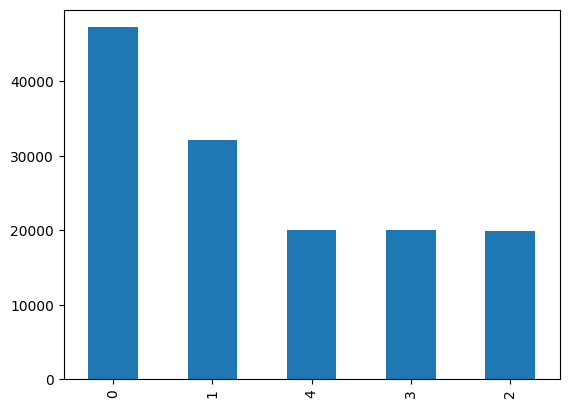

In [ ]:
train_set_augmented['class'].value_counts().plot(kind = "bar")

In [ ]:
train_set_augmented['class'].value_counts()

0    47259
1    32102
4    20000
3    19998
2    19975
Name: class, dtype: int64

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# # Assuming you have X_train and y_train as your training data

# # Instantiate the RandomUnderSampler
# rus = RandomUnderSampler()


# # Perform undersampling
# x_train_resampled, y_train_resampled = rus.fit_resample(train_set_augmented.drop('class', axis = 1), train_set_augmented['class'])
# train_set_resampled = pd.concat([x_train_resampled, y_train_resampled], axis = 1)
# train_set_resampled.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain_multi_noncombined_resampled.txt", index = False)

## over + under sampling multi

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Specify the desired class ratios or specific classes to resample
sampling_strategy = {
    0: 20000,  # Number of samples for class normal
    1: 20000,  # Number of samples for class DoS
}

# Assuming you have X_train and y_train as your training data

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)


# Perform undersampling
X_train_resampled, y_train_resampled = rus.fit_resample(train_set_augmented.drop('class', axis = 1), train_set_augmented['class'])

In [ ]:
y_train_resampled.value_counts()

0    20000
1    20000
4    20000
3    19998
2    19975
Name: class, dtype: int64

In [ ]:
undersampled_train_data = pd.concat((X_train_resampled, y_train_resampled), axis = 1 )

In [ ]:
undersampled_train_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0.000000,3.188489e-08,9.695120e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.000000,6.650899e-06,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.000000,2.144984e-07,3.290234e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.000000,3.260955e-08,6.030823e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.000000,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99968,0.004250,1.115881e-06,2.162885e-06,0.0,0.0,0.0,0.038961,0.0,1.0,0.000541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
99969,0.001056,1.694989e-06,2.903756e-06,0.0,0.0,0.0,0.038961,0.0,1.0,0.000305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
99970,0.001107,1.740625e-06,2.913143e-06,0.0,0.0,0.0,0.038961,0.0,1.0,0.000267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
99971,0.001465,1.686374e-06,3.240436e-06,0.0,0.0,0.0,0.038961,0.0,1.0,0.000116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4


In [ ]:
#some stats
#undersampled_train_data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

In [ ]:
undersampled_train_data.to_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain_multi_noncombined_resampled.txt", index = False)